# Assignment 1

In [1]:
import re
import helper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ODI_DATASET_PATH = './data/ODI-2022.csv'

In [2]:
# # load csv file to pandas dataframe to retrieve column names
# df_temp= pd.read_csv("./data/ODI-2022.csv", delimiter=";")
# df_temp

In [3]:
# Initialize 2 dimensional array
dataset = helper.get_data(ODI_DATASET_PATH)
# Initialize columns
columns = list(zip(*dataset))

# print("What programme are you in? = {}".format(columns[1]))
# print("Have you taken a course on machine learning? = {}".format(columns[2]))
# print("Have you taken a course on information retrieval?; = {}".format(columns[3]))
# # mu is yes, sigma is no
# print("Have you taken a course on statistics? = {}".format(columns[4]))
# print("Have you taken a course on databases? = {}".format(columns[5]))
# print("What is your gender? = {}".format(columns[6]))
# print("Chocolate makes you..... = {}".format(columns[7]))
# print("When is your birthday (date)? = {}".format(columns[8]))
# print("Number of neighbors sitting around you? = {}".format(columns[9]))
# print("Did you stand up? = {}".format(columns[10]))
# print("What is your stress level (0-100)? = {}".format(columns[11]))
# print("You can get 100 euros if you win a local DM competition, or we don’t hold any competitions and I give everyone some money (not the same amount!). How much do you think you would deserve then? = {}".format(columns[12]))
# print("Give a random number = {}".format(columns[13]))
# print("Time you went to be Yesterday = {}".format(columns[14]))
# print("What makes a good day for you (1)?; = {}".format(columns[15]))
# print("What makes a good day for you (2)? = {}".format(columns[16]))



c:\Users\Konstantin\Documents\Masters\Data Mining\dmt-assignment-1\assignment_1\helper.py:5: ConversionWarning: Some errors were detected !
    Line #150 (got 13 columns instead of 17)
    Line #207 (got 18 columns instead of 17)
  array = np.genfromtxt(file_name, dtype=datatype, delimiter=";", invalid_raise=False, skip_header=True)


In [4]:
# load csv file to pandas dataframe to retrieve column names
df_temp= pd.read_csv("./data/ODI-2022.csv", delimiter=";")
column_names = df_temp.columns

# convert dataset to pandas dataframe using column names from df_temp
df = pd.DataFrame(dataset)
df.columns=column_names

df_temp = df_temp.drop(labels=148, axis=0)
df_temp = df_temp.drop(labels=205, axis=0)

## clean all column values
# remove unimportant columns
df = df.drop("Tijdstempel", axis=1) # remove Tijdstempel column because it has no meaning
df = df.drop("Did you stand up?", axis=1) # remove stand up column because it has no meaning
df = df.drop("Number of neighbors sitting around you?", axis=1) # remove neighbours column because it has no meaning
df = df.drop("Give a random number", axis=1) # remove random number column because it has no meaning

# convert column values to boolean for yes/no questions
df['Have you taken a course on machine learning?'] = df['Have you taken a course on machine learning?'].replace(['yes','no','unknown'],[1,0,np.nan])
df['Have you taken a course on information retrieval?'] = df['Have you taken a course on information retrieval?'].replace([1,0,-1],[1,0, np.nan])
df['Have you taken a course on statistics?'] = df['Have you taken a course on statistics?'].replace(['mu','sigma', 'unknown'],[1,0,np.nan])
df['Have you taken a course on databases?'] = df['Have you taken a course on databases?'].replace(['ja','nee', 'unknown'],[1,0,np.nan])

# only keep years in birthday column
def get_year(date):
    year = re.search('[0-9]{4}', date)
    symbols = {'/', '.', '-'}
    if year == None:
        if len(date) > 4 and any(sym in date for sym in symbols):
            year = "19" + date[-2:]
            if year.isdecimal():
                year = int(year)
                if 1930 > year:
                    return np.nan
                elif year > 2005:
                    return np.nan
                else:
                    return year
            else:
                return np.nan
        else:
            return np.nan
    else:
        year = int(year.group(0))
        if 1930 > year:
            return np.nan
        elif year > 2005:
            return np.nan
        else:
            return year

# iterate all rows of birthday column and set all birthdays to year
for index, row in df.iterrows():
    birthday = (row["When is your birthday (date)?"])
    new_birthday = get_year(birthday)
    df['When is your birthday (date)?'] = df['When is your birthday (date)?'].replace([birthday],new_birthday)

# clean stress level column --> set all values < 0 to 0 and > 100 to 100
df = df.astype({'What is your stress level (0-100)?': int}, errors='raise')
df['What is your stress level (0-100)?'].values[df['What is your stress level (0-100)?'].values > 100] = 100
df['What is your stress level (0-100)?'].values[df['What is your stress level (0-100)?'].values < 0] = 0

# clean competition column --> set all values < 0 to 0 and > 100 to 100
df.rename(columns = {'You can get 100 euros if you win a local DM competition, or we don’t hold any competitions and I give everyone some money (not the same amount!). How much do you think you would deserve then? ':'Competition'}, inplace = True)
df = df.astype({'Competition': int}, errors='raise')
df['Competition'].values[df['Competition'].values > 100] = 100
df['Competition'].values[df['Competition'].values < 0] = 0

# clean bedtime column
df.rename(columns={'Time you went to be Yesterday': 'Bedtime'}, inplace=True)

def clean_time(old):
    symbols = {'am', 'pm'}
    old = old.lower()
    if re.match('^[0-9]{2}\:[0-9]{2}$', old):
        return old
    elif re.match('^[0-9]{2}\:[0-9]{2}$', old[0:5]):
        return old[0:5]
    elif re.match('^[0-9]{2}$', old):
        keep = {'9', '10', '11', '12', '21', '22', '23', '24'}
        if old in keep:
            return old + ':' + '00'
        else:
            return np.nan
    elif re.match('^[0-9]{2}\.[0-9]{2}$', old):
        return old[0:2] + ':' + old[3:5]
    elif re.match('^[0-9]{1}\.[0-9]{2}$', old):
        return '0' + old[0] + ':' + old[2:4]
    elif re.match('^[0-9]{1}\:[0-9]{2}$', old):
        return '0' + old
    elif len(old) == 1:
        return np.nan
    elif re.match('^[0-9]{4}$', old):
        return old[0:2] + ':' + old[2:4]
    elif any(sym in old[-2:] for sym in symbols):
        digits = re.sub('[^0-9]', '', old)
        if len(digits) == 4:
            return digits[0:2] + ':' + digits[2:4]
        elif len(digits) == 3:
            return '0' + digits[0] + ':' + digits[1:3]
        elif len(digits) == 2:
            if int(digits) > 9:
                return digits + ':' + '00'
            else:
                return '00' + ':' + digits
        elif len(digits) == 1:
            return '0' + digits + ':00'
        else:
            return np.nan
    else:
        return np.nan

for index, row in df.iterrows():
    old_time = (row['Bedtime'])
    new_time = clean_time(old_time)
    df['Bedtime'] = df['Bedtime'].replace([old_time], new_time)

# clean good day columns
df.rename(columns={'What makes a good day for you (1)?': 'Good day (1)'}, inplace=True)
df.rename(columns={'What makes a good day for you (2)?': 'Good day (2)'}, inplace=True)

# set1 = set(df['Good day (1)'])
# set2 = set(df['Good day (2)'])
# together = set1.union(set2)
# print(len(together))



Text(0.5, 0, 'Frequency')

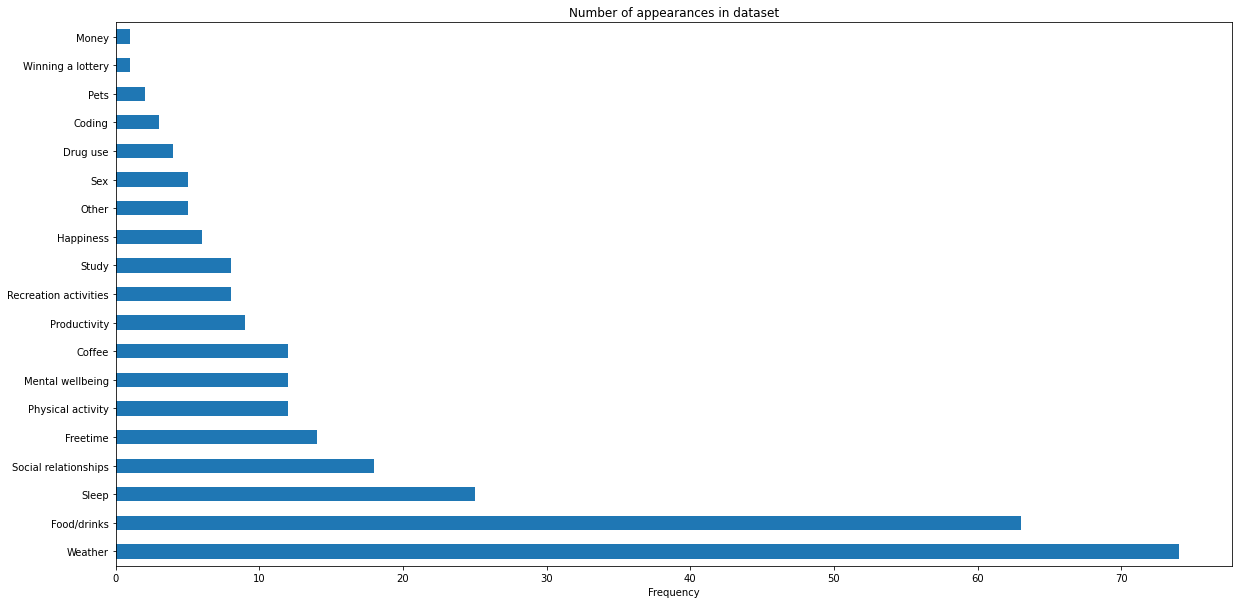

In [5]:
"""Dealing with the last column"""

# divide answers into categories for analyses
df.loc[df['Good day (1)'].str.contains('coffee|flat white', case=False), 'Good day (1)'] = 'Coffee'
df.loc[df['Good day (1)'].str.contains('sun|rain|weather|wind|skies', case=False), 'Good day (1)'] = 'Weather'
df.loc[df['Good day (1)'].str.contains('sleep|early|wake up late|good night', case=False), 'Good day (1)'] = 'Sleep'
df.loc[df['Good day (1)'].str.contains('friend|family|social|people|Kafeneion Amsterdam|Party', case=False), 'Good day (1)'] = 'Social relationships'
df.loc[df['Good day (1)'].str.contains('sport|volley|gym|football|tennis|bouldering|biking|exercise|workout|Cycling', case=False), 'Good day (1)'] = 'Physical activity'
df.loc[df['Good day (1)'].str.contains('food|drinks|breakfast|drinking|pasta|lasagne|chocolate|beer|cookies|meal|sushi|cake|alcohol|croissant|snacks|bread|Winkel apple pie|snickers|Frozen yoghurt|nice dinner|brownies|pizza|thuisbezorgd', case=False), 'Good day (1)'] = 'Food/drinks'
df.loc[df['Good day (1)'].str.contains('mental|stress|relax|mood|satisfaction|being stoic|complications|feeling content|silence', case=False), 'Good day (1)'] = 'Mental wellbeing'
df.loc[df['Good day (1)'].str.contains('happy|joy|Laughter|smiles|smile', case=False), 'Good day (1)'] = 'Happiness'
df.loc[df['Good day (1)'].str.contains('no l|no d|not h|homework|dues|freedom|free time|no cl|time for myself|No obligations|no work|nothing important|Quality time spent|saturday', case=False), 'Good day (1)'] = 'Freetime' # Category to avoid clashings with the word 'lecture'/ no deadlines/ not having to get up early
df.loc[df['Good day (1)'].str.contains('productiv|good work|work done|challeging works|working hard|early|Flow state|insightful things', case=False), 'Good day (1)'] = 'Productivity'
df.loc[df['Good day (1)'].str.contains('lecture|datamining|passing|grades|studying', case=False), 'Good day (1)'] = 'Study' 
df.loc[df['Good day (1)'].str.contains('drugs|xtc', case=False), 'Good day (1)'] = 'Drug use'
df.loc[df['Good day (1)'].str.contains('Green', case=True), 'Good day (1)'] = 'Drug use'
df.loc[df['Good day (1)'].str.contains('head|sex', case=False), 'Good day (1)'] = 'Sex'
df.loc[df['Good day (1)'].str.contains('movies|game|reading|playing|VIKINGS|having fun|music', case=False), 'Good day (1)'] = 'Recreation activities' # Could be mixed with 'Freetime'?
df.loc[df['Good day (1)'].str.contains('coding|debugging|Applying data mining techniques', case=False), 'Good day (1)'] = 'Coding' 
df.loc[df['Good day (1)'].str.contains('my cat', case=False), 'Good day (1)'] = 'Pets'
df.loc[df['Good day (1)'].str.contains('Cat', case=True), 'Good day (1)'] = 'Pets'
df.loc[df['Good day (1)'].str.contains('Win lottery', case=False), 'Good day (1)'] = 'Winning a lottery'
df.loc[df['Good day (1)'].str.contains('Ether in the green', case=False), 'Good day (1)'] = 'Money'
df.loc[df['Good day (1)'].str.contains('Come up with a good question|good|surveys|waking up|alive', case=False), 'Good day (1)'] = 'Other'
df.loc[df['Good day (1)'].str.contains('Free', case=True), 'Good day (1)'] = 'Freetime'




df.loc[df['Good day (1)'].str.contains('Love', case=True), 'Good day (1)'] = 'ZAK' # for the str with love and emoji in it
df.loc[df['Good day (1)'].str.contains('7777|0|6|see you smile|1|yes|Χρεσης|3|I don|Wakker worden naast Lieke|Andrea|Lemons|no idea|Kissing thomas', case=False), 'Good day (1)'] = 'ZAK'

# Replace '2', '9', '-' by checking length of string to avoid clashes with other strings such as '420'
df['Good day (1)'] = df['Good day (1)'].apply(lambda i: i if len(i) > 1 else 'ZAK')


# Change strings of 'ZAK' to np.NaN
df['Good day (1)'] = df['Good day (1)'].replace('ZAK', np.nan)

# value count the strings to plot them in bar chart
df['Good day (1)'].value_counts().plot(kind='barh', figsize=(20, 10))
plt.title('Number of appearances in dataset')
plt.xlabel('Frequency')

# Ranges of values
# Distribution of values,
# relationships between attributes
# and so on.

# Make list of the first column for reference
# mark_list = df['Good day (1)'].tolist()
# print(mark_list)

Text(0.5, 0, 'Frequency')

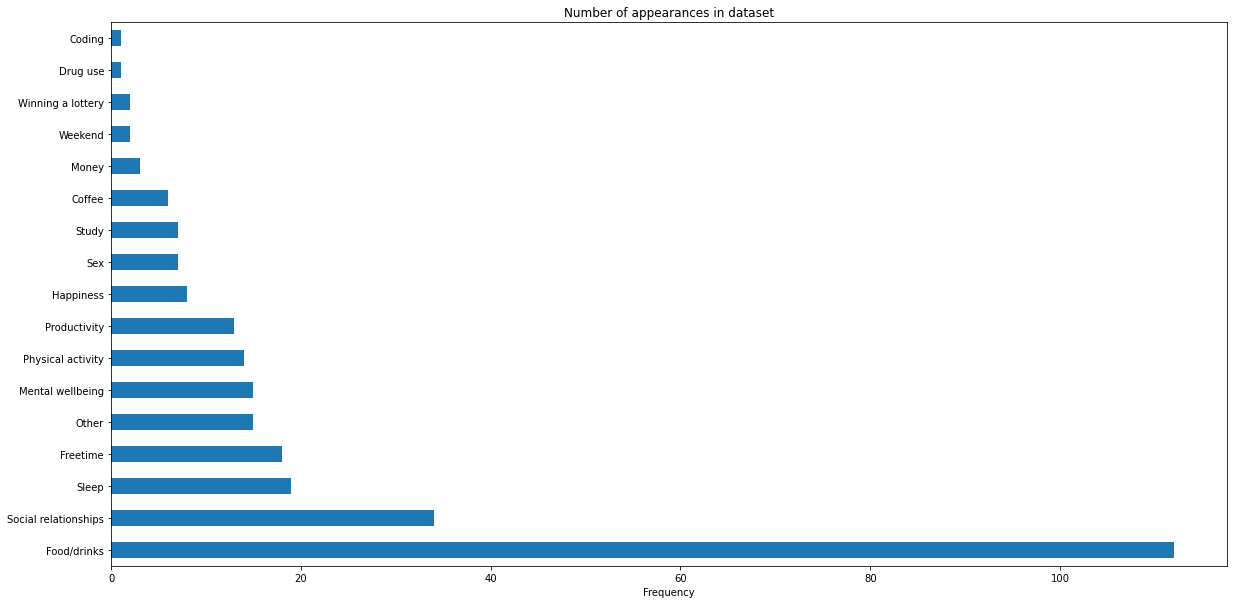

In [6]:
"""Dealing with the last column"""

# divide answers into categories for analyses
df.loc[df['Good day (2)'].str.contains('coffee|flat white', case=False), 'Good day (2)'] = 'Coffee'
df.loc[df['Good day (2)'].str.contains('sun|rain|weather|wind|skies|Spring|Warmth|Nice whether', case=False), 'Good day (2)'] = 'Weather'
df.loc[df['Good day (2)'].str.contains('sleep|early|wake up late|good night|My bed', case=False), 'Good day (2)'] = 'Sleep'
df.loc[df['Good day (2)'].str.contains('friend|family|social|people|Kafeneion Amsterdam|Party|call my mother', case=False), 'Good day (2)'] = 'Social relationships'
df.loc[df['Good day (2)'].str.contains('sport|volley|gym|football|tennis|bouldering|biking|exercise|workout|Cycling|Activity', case=False), 'Good day (2)'] = 'Physical activity'
df.loc[df['Good day (2)'].str.contains('food|BBQ|Wine|drinks|breakfast|drinking|pasta|lasagne|eating|go to restaurant|chocolate|beer|cookies|meal|sushi|cake|alcohol|Lemonade|A cool glass of water|croissant|snacks|Water|bread|Pie|Winkel apple pie|snickers|Frozen yoghurt|nice dinner|brownies|pizza|thuisbezorgd', case=False), 'Good day (2)'] = 'Food/drinks'
df.loc[df['Good day (2)'].str.contains('mental|stress|relax|mood|satisfaction|being stoic|complications|feeling content|Feeling in tune with yourself and your surroundings|not thinking about tomorrow|silence|accepting change|Meditation|Knowing i have a spare day|fun stuff on the planning', case=False), 'Good day (2)'] = 'Mental wellbeing'
df.loc[df['Good day (2)'].str.contains('happy|joy|Laughter|smiles|smile|happiness|Laugh', case=False), 'Good day (2)'] = 'Happiness'
df.loc[df['Good day (2)'].str.contains('no l|no d|not h|homework|dues|freedom|free time|no home assignment|No responsibility|no cl|time for myself|No obligations|no work|nothing important|Quality time spent|Vacation|saturday|no school|Day off|holiday|No assignments|Spare', case=False), 'Good day (2)'] = 'Freetime' # Category to avoid clashings with the word 'lecture'/ no deadlines/ not having to get up early
df.loc[df['Good day (2)'].str.contains('productiv|good work|work done|challeging works|working hard|early|Flow state|insightful things|challenge|finishing things for the day|make progress in anything|Something to achieve in the day|Plan|Neat room|Completed to-do', case=False), 'Good day (2)'] = 'Productivity'
df.loc[df['Good day (2)'].str.contains('lecture|datamining|passing|grades|studying|progress in the course|learning', case=False), 'Good day (2)'] = 'Study'
df.loc[df['Good day (2)'].str.contains('DMT', case=True), 'Good day (2)'] = 'Study'
df.loc[df['Good day (2)'].str.contains('drugs|xtc|smoke weed', case=False), 'Good day (2)'] = 'Drug use'
df.loc[df['Good day (2)'].str.contains('Green', case=True), 'Good day (2)'] = 'Drug use'
df.loc[df['Good day (2)'].str.contains('head|sex|lover', case=False), 'Good day (2)'] = 'Sex'
df.loc[df['Good day (2)'].str.contains('movies|game|gaming|reading|playing|VIKINGS|having fun|music|series|Ajax|beach|Books|Anime|Fun stuff to do|Time to read|Netflix|going outside', case=False), 'Good day (2)'] = 'Recreation activities' # Could be mixed with 'Freetime'?
df.loc[df['Good day (2)'].str.contains('coding|debugging|Applying data mining techniques|data mining', case=False), 'Good day (2)'] = 'Coding' 
df.loc[df['Good day (2)'].str.contains('my cat', case=False), 'Good day (2)'] = 'Pets'
df.loc[df['Good day (2)'].str.contains('Cat', case=True), 'Good day (2)'] = 'Pets'
df.loc[df['Good day (2)'].str.contains('Win lottery|Winning the lottery|Winning a lottery', case=False), 'Good day (2)'] = 'Winning a lottery'
df.loc[df['Good day (2)'].str.contains('Ether in the green|money', case=False), 'Good day (2)'] = 'Money'
df.loc[df['Good day (2)'].str.contains('Come up with a good question|good|surveys|waking up|alive|faces|monk|awake|beautiful girl|A dm QA|feyenoord winning|No E|Diet on point', case=False), 'Good day (2)'] = 'Other'
df.loc[df['Good day (2)'].str.contains('Free', case=True), 'Good day (2)'] = 'Freetime'
df.loc[df['Good day (2)'].str.contains('eat', case=True), 'Good day (2)'] = 'Food/drinks'
df.loc[df['Good day (2)'].str.contains('love', case=True), 'Good day (2)'] = 'Social relationships'


df.loc[df['Good day (2)'].str.contains('No', case=True), 'Good day (2)'] = 'ZAK'
df.loc[df['Good day (2)'].str.contains('Love', case=True), 'Good day (2)'] = 'ZAK' # for the str with love and emoji in it
df.loc[df['Good day (2)'].str.contains('7777|0|6|see you smile|1|yes|Χρεσης|3|I don|Geen ontbijt met Jan|Wakker worden naast Lieke|Andrea|Lemons|I really don|no idea|I answered it already|Kissing thomas|drink day before|More jou|Φετα|date|Angela|WFH|My house not burning down', case=False), 'Good day (2)'] = 'ZAK'
df.loc[df['Good day (2)'].str.contains('fun', case=True), 'Good day (2)'] = 'Happiness'
df.loc[df['Good day (2)'].str.contains('Fun', case=True), 'Good day (2)'] = 'Happiness'

# Replace '2', '9', '-' by checking length of string to avoid clashes with other strings such as '420'
df['Good day (2)'] = df['Good day (2)'].apply(lambda i: i if len(i) > 1 else 'ZAK')


# Change strings of 'ZAK' to np.NaN
df['Good day (2)'] = df['Good day (2)'].replace('ZAK', np.nan)

# value count the strings to plot them in bar chart
df['Good day (2)'].value_counts().plot(kind='barh', figsize=(20, 10))
plt.title('Number of appearances in dataset')
plt.xlabel('Frequency')

# Make list of the first column for reference
# mark_list = list(df['Good day (2)'].unique())
# print(mark_list)



Text(0.5, 0, 'Frequency')

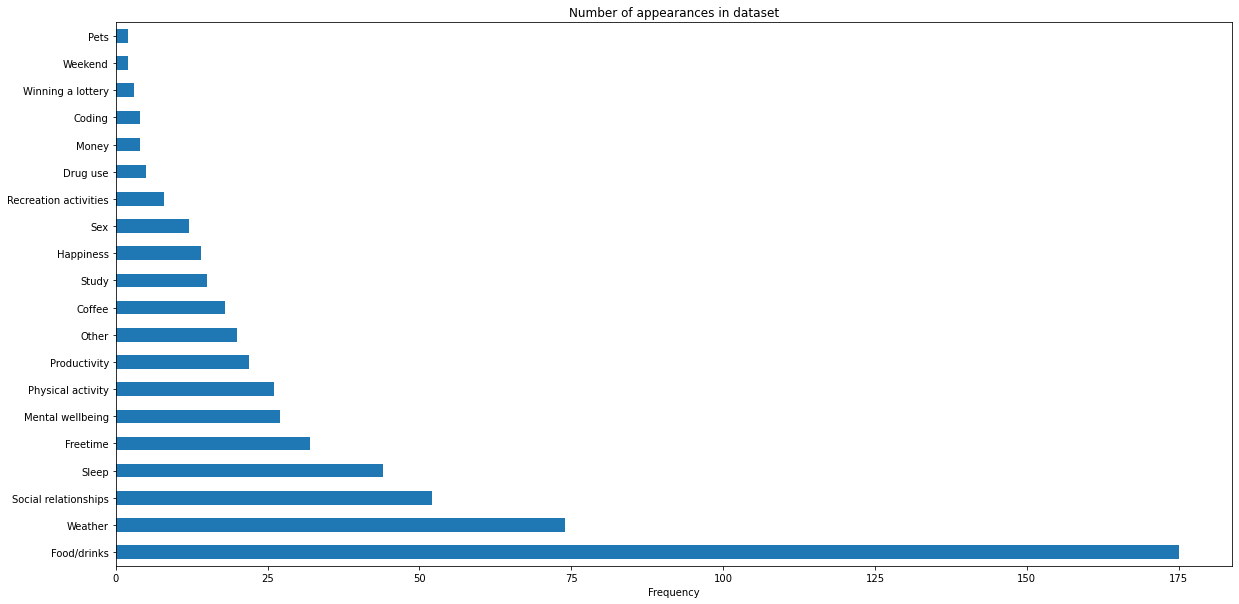

In [7]:
"""Combining the last two columns together to plot"""

combined_columns = [df['Good day (1)'], df['Good day (2)']]
res = pd.concat(combined_columns)

res.value_counts().plot(kind='barh', figsize=(20, 10))
plt.title('Number of appearances in dataset')
plt.xlabel('Frequency')


In [8]:
# clean gender column
#df['What is your gender?'] = df['What is your gender?'].replace(['not willing to answer'],[np.nan])
display(df)

,What programme are you in?,Have you taken a course on machine learning?,Have you taken a course on information retrieval?,Have you taken a course on statistics?,Have you taken a course on databases?,What is your gender?,Chocolate makes you.....,When is your birthday (date)?,What is your stress level (0-100)?,Competition,Bedtime,Good day (1),Good day (2)
0,artificial intelligence,1.0,0.0,1.0,0.0,female,neither,1998.0,0,5,23:00,Coffee,Food/drinks
1,big data,1.0,0.0,1.0,0.0,male,fat,2000.0,100,1,NaN,NaN,NaN
2,Computational Science,1.0,1.0,1.0,1.0,male,fat,1998.0,0,100,NaN,NaN,NaN
3,Bioinformatics and Systems Biology,1.0,0.0,NaN,0.0,male,neither,1997.0,20,100,14:00,Food/drinks,Mental wellbeing
4,AI,1.0,1.0,1.0,1.0,male,fat,1997.0,2,100,07:20,Weather,Food/drinks
...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,Ai,1.0,1.0,NaN,0.0,not willing to answer,fat,1956.0,30,99,NaN,NaN,NaN
298,E,1.0,1.0,1.0,1.0,male,slim,NaN,9,5,NaN,NaN,NaN
299,MSc Computational Science,0.0,0.0,1.0,0.0,male,I have no idea what you are talking about,1995.0,100,1,NaN,Food/drinks,Sleep
300,Artificial Intelligence,1.0,0.0,1.0,0.0,not willing to answer,neither,NaN,70,87,NaN,Weather,Mental wellbeing


<AxesSubplot:xlabel='Courses followed', ylabel='What is your stress level (0-100)?'>

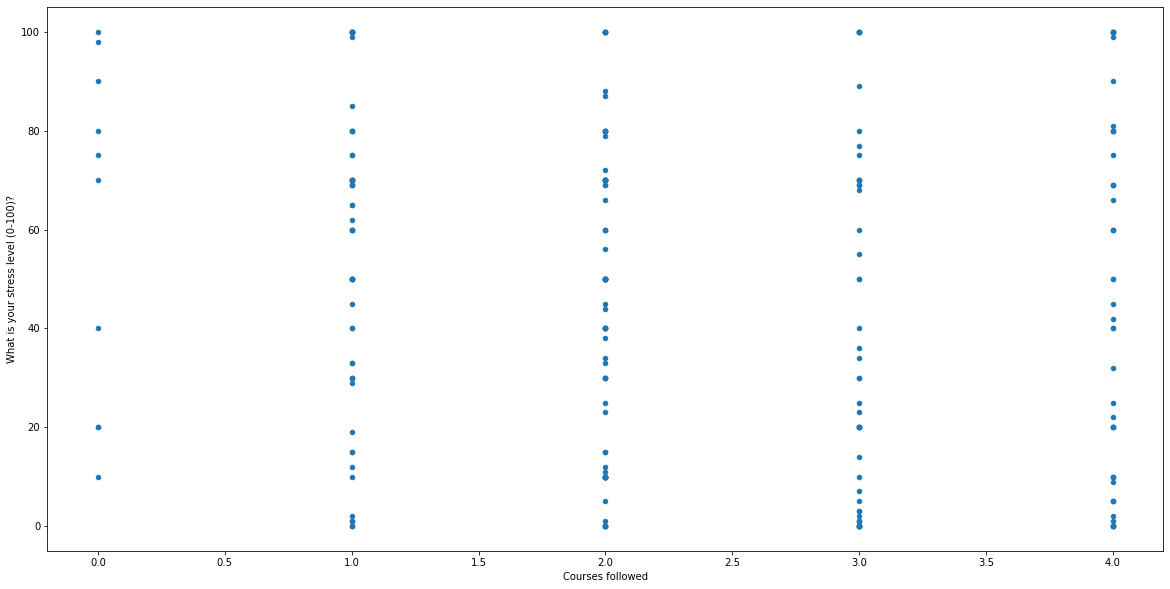

In [9]:
df['Courses followed'] = df['Have you taken a course on machine learning?'] + df['Have you taken a course on information retrieval?'] + df['Have you taken a course on statistics?'] + df['Have you taken a course on databases?']

df.plot(x='Courses followed', y='What is your stress level (0-100)?', kind='scatter', figsize=(20, 10))

Text(0.5, 1.0, 'Number of appearances in dataset')

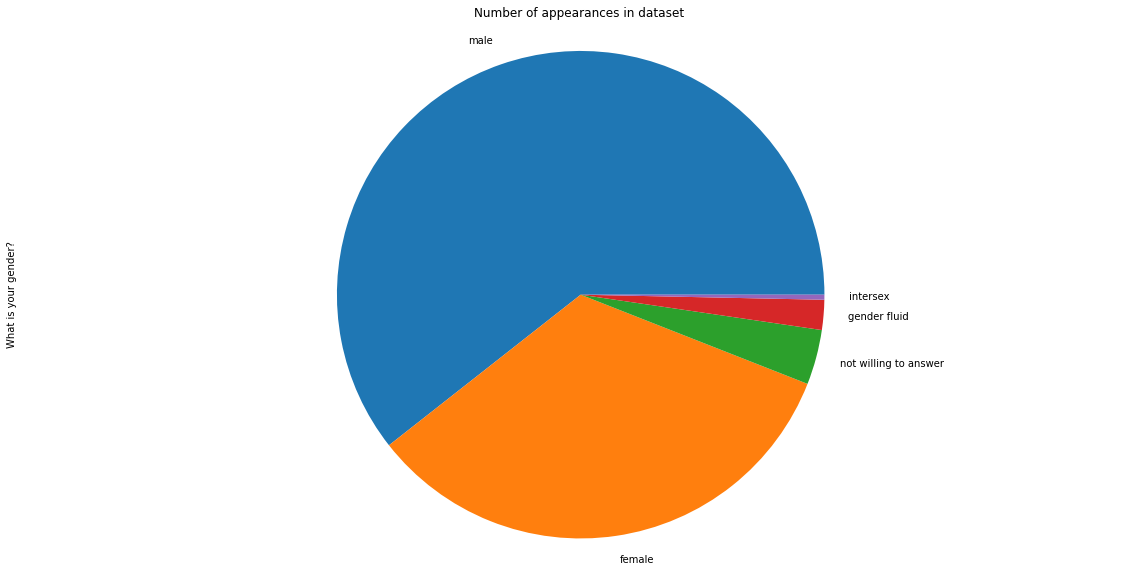

In [10]:
"""Pie chart of genders"""
df['What is your gender?'].value_counts().plot(kind='pie', figsize= (20, 10))
plt.axis('equal')
plt.title('Number of appearances in dataset')

<AxesSubplot:xlabel='Competition', ylabel='What is your stress level (0-100)?'>

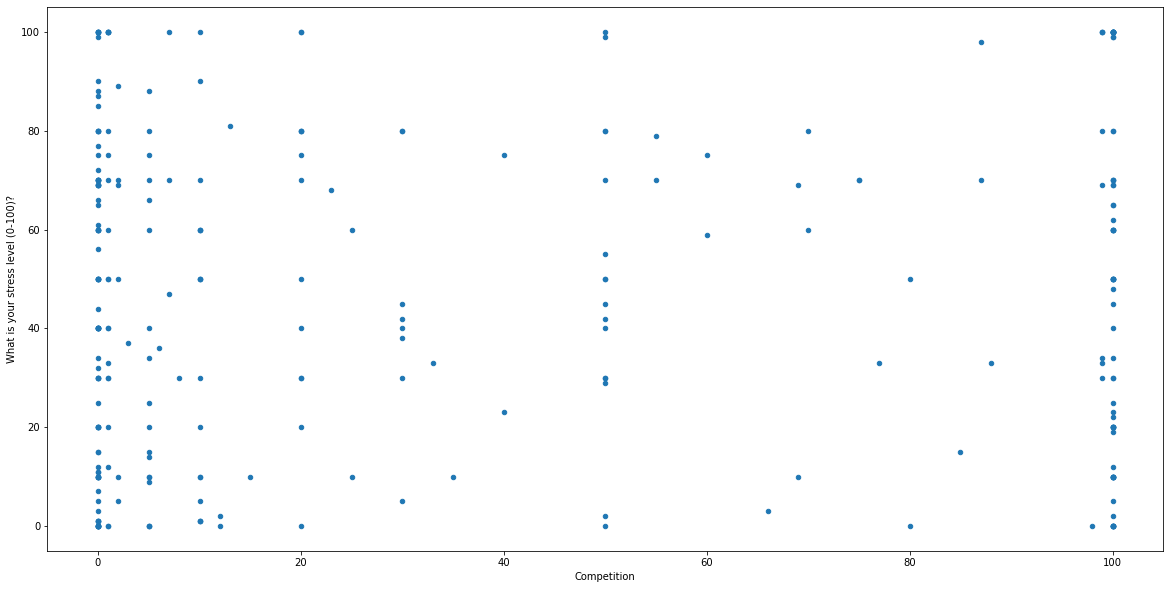

In [11]:
df.plot(x='Competition', y='What is your stress level (0-100)?', kind='scatter', figsize=(20, 10))

In [12]:
for index, row in df.iterrows():
    old_time = (row['Bedtime'])
    if type(old_time) == float:
        continue
    else:
        splitted_time = old_time.split(':')
        int_time = int(splitted_time[1])
        if int_time < 30:
            new_time = int(splitted_time[0])
            df['Bedtime'] = df['Bedtime'].replace([old_time],new_time)
        else:
            new_time = int(splitted_time[0]) + 1
            df['Bedtime'] = df['Bedtime'].replace([old_time],new_time)

In [13]:
display(df['Bedtime'])

0      23.0
1       NaN
2       NaN
3      14.0
4       7.0
       ... 
297     NaN
298     NaN
299     NaN
300     NaN
301     4.0
Name: Bedtime, Length: 302, dtype: float64

<AxesSubplot:xlabel='Bedtime', ylabel='What is your stress level (0-100)?'>

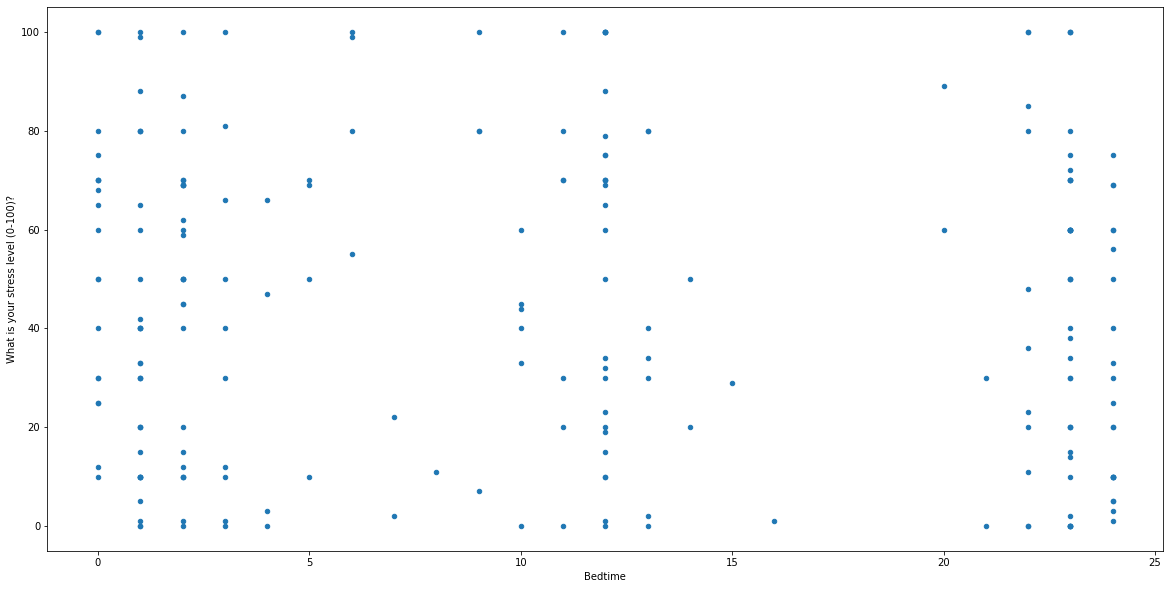

In [18]:
df.plot(x='Bedtime', y='What is your stress level (0-100)?', kind='scatter', figsize=(20, 10))

<AxesSubplot:xlabel='What is your gender?', ylabel='What is your stress level (0-100)?'>

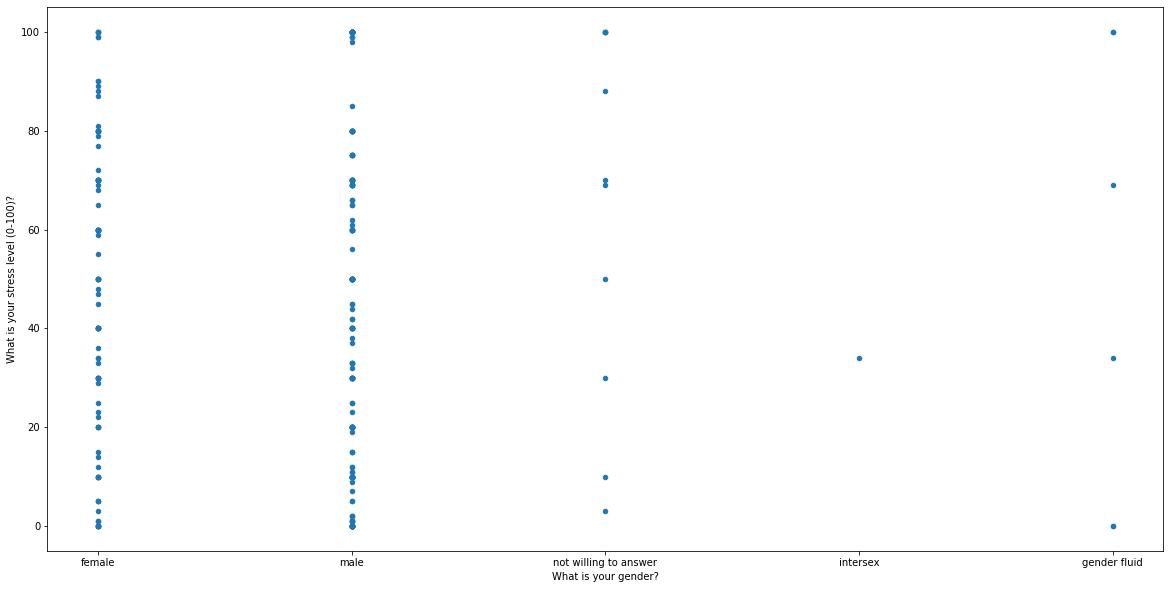

In [15]:
df.plot(x='What is your gender?', y='What is your stress level (0-100)?', kind='scatter', figsize=(20, 10))

In [16]:
# How many records are there
n_records = df.shape[0]
print(f"There are {n_records} records in the file.")

# How many attributes?
n_attributes = len(df.columns)
print(f"There are {n_attributes} attributes in the file.")

# Make various plots of the data. Is there something interesting worth reporting? Re-
# port the figures, discuss what is in them. What meaning do those bars, lines, dots, etc.
# convey? Please select essential and interesting plots for discussion, as you have limited
# space for reporting your findings (see details in a later section).

There are 302 records in the file.
There are 14 attributes in the file.
